In [1]:
!pip install -q pandas numpy matplotlib seaborn plotly

In [2]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
import io
import shutil

sns.set(style='whitegrid')

In [3]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 120)


In [4]:
CAND_NAME = 'varsha_narwariya'
ROOT_DIR = Path(f'ds_{CAND_NAME}')
CSV_DIR = ROOT_DIR / 'csv_files'
OUT_DIR = ROOT_DIR / 'outputs'
ROOT_DIR.mkdir(exist_ok=True)
CSV_DIR.mkdir(exist_ok=True)
OUT_DIR.mkdir(exist_ok=True)

In [5]:
print('Created directories:')
print('-', ROOT_DIR)
print('-', CSV_DIR)
print('-', OUT_DIR)

Created directories:
- ds_varsha_narwariya
- ds_varsha_narwariya/csv_files
- ds_varsha_narwariya/outputs


In [6]:
print('Please upload these two files when prompted: historical_data.csv, fear_greed_index.csv')
uploaded = files.upload()

Please upload these two files when prompted: historical_data.csv, fear_greed_index.csv


Saving historical_data.csv to historical_data.csv
Saving fear_greed_index.csv to fear_greed_index.csv


In [51]:
HIST_FILE = 'historical_data.csv'
SENT_FILE = 'fear_greed_index.csv'

In [52]:
if HIST_FILE not in uploaded and not Path(HIST_FILE).exists():
    # try to find a csv in uploads that looks like it
    for name in uploaded:
        if 'histor' in name.lower() or 'hyper' in name.lower() or 'trades' in name.lower():
            HIST_FILE = name
            break

In [53]:
if SENT_FILE not in uploaded and not Path(SENT_FILE).exists():
    for name in uploaded:
        if 'fear' in name.lower() or 'greed' in name.lower() or 'sentiment' in name.lower():
            SENT_FILE = name
            break

In [54]:
print('Using files:')
print('-', HIST_FILE)
print('-', SENT_FILE)

Using files:
- historical_data.csv
- fear_greed_index.csv


In [55]:
trades = pd.read_csv(HIST_FILE)
sentiment = pd.read_csv(SENT_FILE)

print('\ntrades shape:', trades.shape)
print('sentiment shape:', sentiment.shape)


trades shape: (211224, 16)
sentiment shape: (2644, 4)


In [56]:
# show top rows for quick sanity check
print('\ntrades columns:', list(trades.columns)[:20])
print('\nsentiment columns:', list(sentiment.columns)[:20])


trades columns: ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']

sentiment columns: ['timestamp', 'value', 'classification', 'date']


In [57]:
date_col = None
for c in ['time','timestamp','datetime','date','trade_time','created_at']:
    if c in trades.columns:
        date_col = c
        break

In [58]:
if date_col is None:
    # fallback: try to find a column with 'time' or 'date' in the name
    for c in trades.columns:
        if 'time' in c.lower() or 'date' in c.lower():
            date_col = c
            break

In [59]:
if date_col is None:
    print('No obvious date column in trades — printing column names for inspection')
    print(trades.columns.tolist())
else:
    print('Detected trades datetime column:', date_col)
    trades['time'] = pd.to_datetime(trades[date_col], errors='coerce')

Detected trades datetime column: Timestamp IST


In [60]:
if ('time' not in trades.columns) or trades['time'].isna().all():
    # try epoch column
    epoch_cols = [c for c in trades.columns if 'epoch' in c.lower() or 'ts'==c.lower()]
    if epoch_cols:
        trades['time'] = pd.to_datetime(trades[epoch_cols[0]], unit='s', errors='coerce')

In [61]:
trades['date'] = trades['time'].dt.date

In [62]:
# --- Sentiment: detect date column ---
sent_date_col = None
for c in sentiment.columns:
    if 'date' in c.lower() or 'day' in c.lower():
        sent_date_col = c
        break

In [63]:
if sent_date_col is None:
    # fallback to first column
    sent_date_col = sentiment.columns[0]

sentiment['date'] = pd.to_datetime(sentiment[sent_date_col], errors='coerce')
sentiment['date_only'] = sentiment['date'].dt.date

In [64]:
# Normalize classification column
class_col = None
for c in sentiment.columns:
    if 'class' in c.lower() or 'fear' in c.lower() or 'greed' in c.lower():
        class_col = c
        break

In [65]:
if class_col is None and sentiment.shape[1] > 1:
    class_col = sentiment.columns[1]

if class_col is None:
    sentiment['classification'] = np.nan
else:
    sentiment['classification'] = sentiment[class_col].astype(str).str.strip().str.title()

In [66]:
print('\nSentiment sample:')
print(sentiment[['date_only','classification']].dropna().head())
print('\nTrades sample dates:')
print(trades['date'].dropna().astype(str).unique()[:5])


Sentiment sample:
    date_only classification
0  2018-02-01           Fear
1  2018-02-02   Extreme Fear
2  2018-02-03           Fear
3  2018-02-04   Extreme Fear
4  2018-02-05   Extreme Fear

Trades sample dates:
['2024-02-12' '2024-03-12' '2024-04-12' '2025-04-03' '2025-05-03']


In [67]:
merged = trades.merge(sentiment[['date_only','classification']].drop_duplicates(), left_on='date', right_on='date_only', how='left')
print('Merged shape:', merged.shape)
print('Sentiment value counts in merged:')
print(merged['classification'].value_counts(dropna=False))

Merged shape: (211224, 20)
Sentiment value counts in merged:
classification
NaN              175360
Fear              13869
Greed             11292
Extreme Greed      5621
Neutral            2756
Extreme Fear       2326
Name: count, dtype: int64


In [68]:
merged.to_csv(CSV_DIR / 'merged_trades_with_sentiment.csv', index=False)
print('Saved:', CSV_DIR / 'merged_trades_with_sentiment.csv')

Saved: ds_varsha_narwariya/csv_files/merged_trades_with_sentiment.csv


In [69]:
num_candidate_names = ['closedPnL','closed_pnl','pnl','profit','profit_loss','realized_pnl']
leverage_candidates = ['leverage','lev','leverage_used']
size_candidates = ['size','quantity','qty']
price_candidates = ['execution price','execution_price','price']

In [70]:
pnl_col = None
for c in merged.columns:
    for cand in num_candidate_names:
        if cand.lower() in c.lower():
            pnl_col = c
            break
    if pnl_col:
        break

if pnl_col:
    merged['closedPnL_clean'] = pd.to_numeric(merged[pnl_col], errors='coerce')
else:
    # try columns containing 'pnl'
    pnl_cols = [c for c in merged.columns if 'pnl' in c.lower()]
    if pnl_cols:
        merged['closedPnL_clean'] = pd.to_numeric(merged[pnl_cols[0]], errors='coerce')
    else:
        merged['closedPnL_clean'] = np.nan


In [71]:
lev_col = None
for c in merged.columns:
    if any(cand.lower() == c.lower() for cand in leverage_candidates) or 'leverage' in c.lower():
        lev_col = c
        break
if lev_col:
    merged['leverage_clean'] = pd.to_numeric(merged[lev_col], errors='coerce')
else:
    merged['leverage_clean'] = np.nan

# Size
size_col = None
for c in merged.columns:
    if any(cand.lower() == c.lower() for cand in size_candidates) or 'size' in c.lower():
        size_col = c
        break
if size_col:
    merged['size_clean'] = pd.to_numeric(merged[size_col], errors='coerce')
else:
    merged['size_clean'] = np.nan

In [72]:
price_col = None
for c in merged.columns:
    if any(cand.lower() in c.lower() for cand in price_candidates):
        price_col = c
        break
if price_col:
    merged['price_clean'] = pd.to_numeric(merged[price_col], errors='coerce')
else:
    merged['price_clean'] = np.nan

# Basic PnL flags
merged['is_profit'] = merged['closedPnL_clean'] > 0
merged['is_loss'] = merged['closedPnL_clean'] < 0

print('Numeric columns prepared: closedPnL_clean, leverage_clean, size_clean, price_clean')

Numeric columns prepared: closedPnL_clean, leverage_clean, size_clean, price_clean


In [73]:
# A. PnL by sentiment
pnl_by_sentiment = merged.groupby('classification')['closedPnL_clean'].agg(['count','sum','mean','median','std']).reset_index()
pnl_by_sentiment.to_csv(CSV_DIR / 'pnl_by_sentiment.csv', index=False)
print('Saved:', CSV_DIR / 'pnl_by_sentiment.csv')

# B. Leverage stats by sentiment (if leverage data present)
if 'proxy_leverage' in df.columns:
    plt.figure(figsize=(10,4))
    sns.histplot(df['proxy_leverage'].dropna(), bins=40)
    plt.title('Proxy Leverage Distribution')
    plt.tight_layout()
    fn = OUT_DIR / 'proxy_leverage_distribution.png'
    plt.savefig(fn)
    plt.close()
    print('Saved:', fn)
else:
    print("Skipping — no proxy leverage computed")

# C. Daily trade counts and avg pnl
daily = merged.groupby('date').agg(trades_count=('date','count'), avg_pnl=('closedPnL_clean','mean')).reset_index()
# attach sentiment per day (from sentiment dataset)
per_day_sent = sentiment[['date_only','classification']].drop_duplicates().rename(columns={'date_only':'date'})
per_day_sent['date'] = pd.to_datetime(per_day_sent['date'])
daily['date'] = pd.to_datetime(daily['date'])
daily = daily.merge(per_day_sent, on='date', how='left')
daily.to_csv(CSV_DIR / 'daily_trade_counts.csv', index=False)
print('Saved:', CSV_DIR / 'daily_trade_counts.csv')

# D. Symbol-level performance by sentiment
if 'Coin' in merged.columns:
    sym_stats = merged.groupby(['Coin','classification'])['closedPnL_clean'].agg(['count','sum','mean']).reset_index()
    sym_stats.to_csv(CSV_DIR / 'coin_performance_by_sentiment.csv', index=False)
    print('Saved:', CSV_DIR / 'coin_performance_by_sentiment.csv')
else:
    print('No `symbol` column found; skipping symbol_performance_by_sentiment.csv')

Saved: ds_varsha_narwariya/csv_files/pnl_by_sentiment.csv
Saved: ds_varsha_narwariya/outputs/proxy_leverage_distribution.png
Saved: ds_varsha_narwariya/csv_files/daily_trade_counts.csv
Saved: ds_varsha_narwariya/csv_files/coin_performance_by_sentiment.csv


In [74]:
merged.sample(min(1000, len(merged))).to_csv(CSV_DIR / 'merged_sample.csv', index=False)
print('Saved sample:', CSV_DIR / 'merged_sample.csv')


Saved sample: ds_varsha_narwariya/csv_files/merged_sample.csv


1) Closed PnL by market sentiment (boxplot)

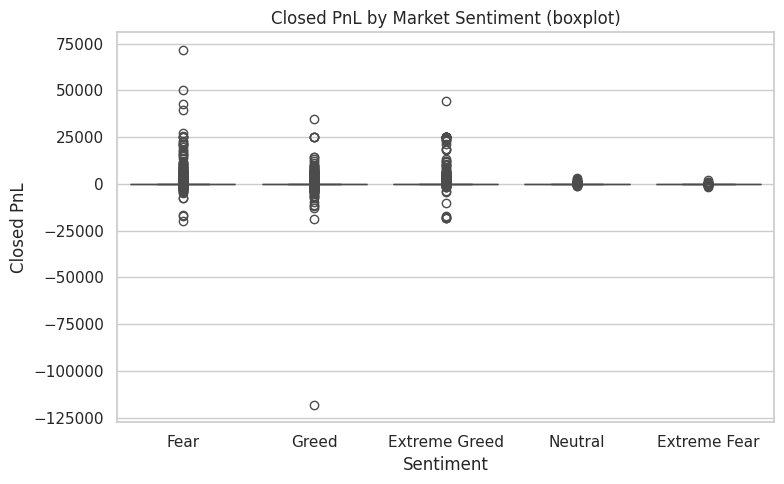

Saved: ds_varsha_narwariya/outputs/pnl_by_sentiment_boxplot.png


In [90]:
plt.figure(figsize=(8,5))
if merged['classification'].notna().any() and merged['closedPnL_clean'].notna().any():
    order = merged['classification'].value_counts().index.tolist()
    sns.boxplot(x='classification', y='closedPnL_clean', data=merged, order=order)
    plt.title('Closed PnL by Market Sentiment (boxplot)')
    plt.xlabel('Sentiment')
    plt.ylabel('Closed PnL')
    fn = OUT_DIR / 'pnl_by_sentiment_boxplot.png'
    plt.tight_layout()
    plt.savefig(fn)
    plt.show()
    plt.close()
    print('Saved:', fn)
else:
    print('Skipping PnL boxplot — missing classification or closedPnL_clean')

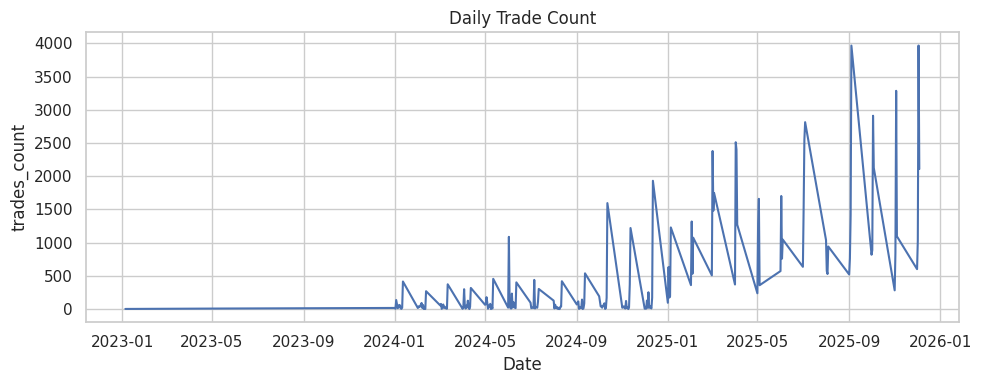

Saved: ds_varsha_narwariya/outputs/daily_trade_count_timeseries.png


In [89]:
if 'date' in daily.columns:
    plt.figure(figsize=(10,4))
    sns.lineplot(x='date', y='trades_count', data=daily)
    plt.title('Daily Trade Count')
    plt.xlabel('Date')
    plt.tight_layout()
    fn = OUT_DIR / 'daily_trade_count_timeseries.png'
    plt.savefig(fn)
    plt.show()
    plt.close()
    print('Saved:', fn)
else:
    print('Skipping daily timeseries — daily not computed')

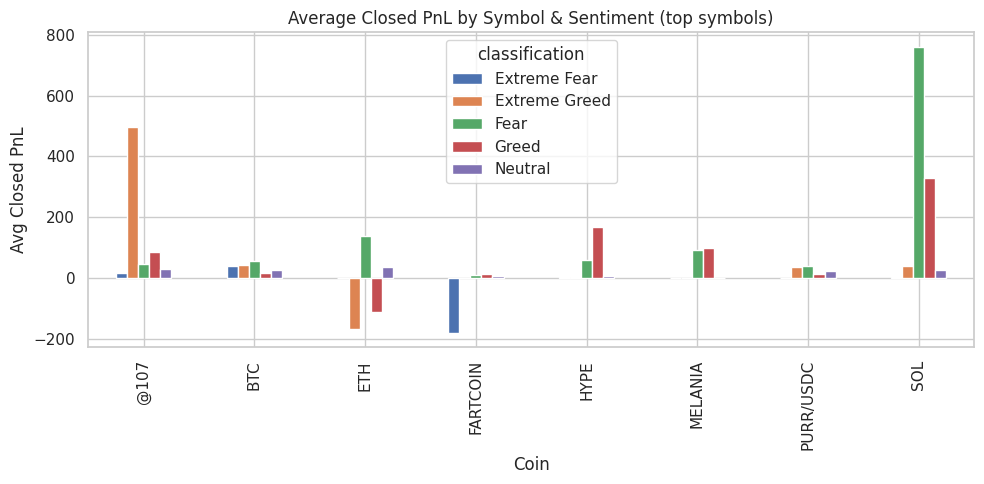

Saved: ds_varsha_narwariya/outputs/symbol_pnl_by_sentiment.png


In [88]:
if 'Coin' in merged.columns and merged['Coin'].notna().any():
    top_symbols = merged['Coin'].value_counts().nlargest(8).index.tolist()
    sym_plot = merged[merged['Coin'].isin(top_symbols)].groupby(['Coin','classification'])['closedPnL_clean'].mean().unstack()
    if not sym_plot.empty:
        sym_plot.plot(kind='bar', figsize=(10,5))
        plt.title('Average Closed PnL by Symbol & Sentiment (top symbols)')
        plt.ylabel('Avg Closed PnL')
        plt.tight_layout()
        fn = OUT_DIR / 'symbol_pnl_by_sentiment.png'
        plt.savefig(fn)
        plt.show()
        plt.close()

        print('Saved:', fn)
    else:
        print('Symbol plot empty — skipping')
else:
    print('Skipping symbol plot — no symbol data')

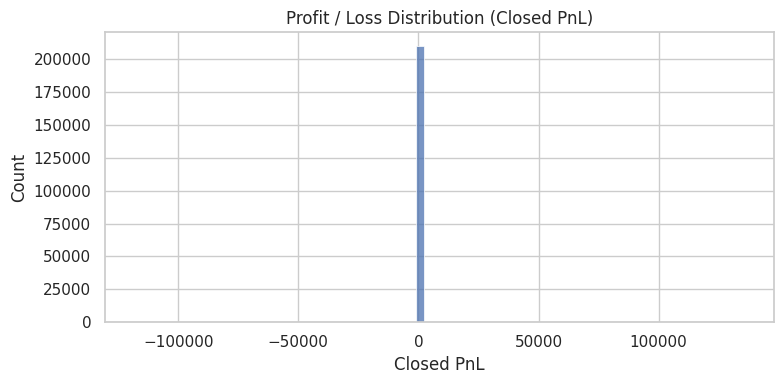

Saved: ds_varsha_narwariya/outputs/profit_loss_distribution.png


In [87]:
if merged['closedPnL_clean'].notna().any():
    plt.figure(figsize=(8,4))
    sns.histplot(merged['closedPnL_clean'].dropna(), bins=80, kde=False)
    plt.title('Profit / Loss Distribution (Closed PnL)')
    plt.xlabel('Closed PnL')
    plt.tight_layout()
    fn = OUT_DIR / 'profit_loss_distribution.png'
    plt.savefig(fn)
    plt.show()
    plt.close()
    print('Saved:', fn)
else:
    print('Skipping P/L distribution — no closedPnL_clean data')

In [82]:
insights = {}
# Average PnL overall and by sentiment
insights['overall_mean_pnl'] = merged['closedPnL_clean'].mean()
insights['overall_median_pnl'] = merged['closedPnL_clean'].median()
insights['pnl_by_sentiment'] = pnl_by_sentiment

print('Overall mean PnL:', insights['overall_mean_pnl'])
print('\nPnL by sentiment:')
print(pnl_by_sentiment)

Overall mean PnL: 48.74900079269401

PnL by sentiment:
  classification  count           sum        mean   median          std
0   Extreme Fear   2326  4.399937e+03    1.891632  0.00000    76.727713
1  Extreme Greed   5621  1.156894e+06  205.816345  0.96048  1861.557119
2           Fear  13869  1.779226e+06  128.287950  0.00000  1342.348497
3          Greed  11292  6.096325e+05   53.988003  0.00000  1399.468182
4        Neutral   2756  7.465674e+04   27.088803  0.00000   142.945889


In [84]:
with open(ROOT_DIR / 'insights_summary.txt', 'w') as f:
    f.write('Quick insights (automatic)\n')
    f.write(f"Overall mean PnL: {insights['overall_mean_pnl']}\n")
    f.write('\nPnL by sentiment:\n')
    pnl_by_sentiment.to_csv(f, index=False)


print('Saved quick insights to', ROOT_DIR / 'insights_summary.txt')

Saved quick insights to ds_varsha_narwariya/insights_summary.txt


In [86]:
zip_name = f"{ROOT_DIR}.zip"
shutil.make_archive(str(ROOT_DIR), 'zip', root_dir='.', base_dir=str(ROOT_DIR))
print('Created zip file:', zip_name)

# Provide the zip for download (Colab will show a link)
files.download(zip_name)

Created zip file: ds_varsha_narwariya.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>